In [8]:
import json
import time
import os
import re
import shlex
import subprocess
import platform
from docker import from_env as docker_client
from dataclasses import dataclass
from datetime import datetime
from configparser import ConfigParser

import pandas as pd
import psycopg

In [ ]:
#loading config
def load_config(filename="database.ini", section="postgresql"):
    parser = ConfigParser()
    parser.read(filename)

    config = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            config[param[0]] = param[1]
    else:
        raise Exception("Section {0} not found in the {1} file".format(section, filename))
    return config

#connecting to db
def connect():
    try:
        pg_conn = psycopg.connect(**load_config(), connect_timeout = 5)
        return pg_conn
    except psycopg.DatabaseError as error:
        raise error

#disconnecting from db
def disconnect(pg_conn, cursor = None):
    if cursor != None:
        cursor.close()
    pg_conn.close()

In [ ]:
#restart db and remove cache if possible
def restart_db():
    env = load_config(section = "docker")

    if env["container_name"] != "":
        try:
            client = docker_client()
            container = client.containers.get(env["container_name"])

            container.stop()
            container.wait()
            container.start()
            
        except Exception as e:
            print(e)
            
    elif platform.system() == "Linux":
        try:
            subprocess.run(["sync"], check=True)

            subprocess.run(['sudo', 'systemctl', 'stop', 'postgresql'], check=True)
            subprocess.run(["sudo", "sh", "-c", "echo 3 > /proc/sys/vm/drop_caches"], check=True)
            subprocess.run(['sudo', 'systemctl', 'start', 'postgresql'], check=True)

        except Exception as e:
            print(e)

    else:
        raise Exception("System configuration not supported")

#wait for db to accept connections
def wait_for_db(timeout = 15):
    start = time.time()

    while time.time() - start < timeout:
        try:
            pg_conn = connect()
            cursor = pg_conn.cursor()

            disconnect(pg_conn, cursor)
            return
        except psycopg.OperationalError:
            time.sleep(1)
    raise TimeoutError("Could not connect to the database")

In [ ]:
#formatting query
def format_query(query):
    #removing comments
    query = re.sub(r"--.*", "", query)
    query = re.sub(r"/\*.*?\*/", "", query, flags = re.DOTALL)
    query = re.sub(r"EXPLAIN (ANALYZE|(\(.*\)))", "", query) #fallback for explain
    
    #joining words with spaces while preserving quoted strings
    query = " ".join(shlex.split(query, posix = False))

    return query

queries = []

#loading all queries
for root, dirs, files in os.walk(os.curdir):
    for file in files:
        if not file.endswith(".sql"):
            continue

        path = os.path.join(root, file)
        query = open(path, "r").read()
        query = format_query(query)

        queries.append([file, query])
        print([file, query])

In [ ]:
#execution settings
precache_repeats = 1
query_repeats = 3
cold_run = False

In [ ]:
@dataclass
class QueryResult:
    label: str
    query: str
    bench_time: datetime
    result_set: dict
    exec_time: float

#executes all statements in query and returns the best result of all precache_repeats
def run_query(query, precache_repeats = 1, cold_run = False):

    if cold_run:
        restart_db()
        wait_for_db()

    pg_conn = connect()
    cursor = pg_conn.cursor()

    for statement in query.split(";"):
        statement = statement.strip()

        if statement == "":
            continue

        if statement.upper().startswith(("CREATE", "REPLACE", "REFRESH", "DROP")):
            cursor.execute(statement)
            continue

        for i in range(precache_repeats):
            bench_start, query_start = datetime.now(), time.perf_counter_ns()
            cursor.execute("EXPLAIN (ANALYZE, BUFFERS, FORMAT JSON, SETTINGS) " + statement)

            result_set = cursor.fetchall()
            query_end = time.perf_counter_ns()

            result = QueryResult(
                label = label,
                query = query,
                bench_time = bench_start,
                result_set = json.dumps(result_set),
                exec_time = query_end - query_start
            )

            if i == 0:
                best_result = result

            if result.exec_time < best_result.exec_time:
                best_result = result
        
    disconnect(pg_conn, cursor)

    return best_result

#executing queries
results: list[QueryResult] = []

for label, query in queries:

    print(label)

    for i in range(query_repeats):
        result = run_query(query, precache_repeats, cold_run)
        results.append(result)

In [ ]:
#saving results
df = pd.DataFrame(results)
df.to_csv("results.csv", index=False)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#plotting results
sns.set_context("talk")
sns.set_palette("viridis")
sns.set_theme(style = "whitegrid")

In [65]:
df = pd.read_csv("results.csv")

def getTotalCost(text):
    match = re.search(r'"Total Cost": (\d+)', text)
    return int(match.group(1)) if match else None

df["Total Cost"] = df["result_set"].apply(getTotalCost)

df["Cost per Time"] = df["Total Cost"]/df["exec_time"]
df["Time per Cost"] = df["exec_time"]/df["Total Cost"]

df["Json"] = "json" in df["label"]

print(df.describe())

          exec_time    Total Cost  Cost per Time  Time per Cost
count  1.590000e+02  1.590000e+02     159.000000     159.000000
mean   2.272703e+09  4.339651e+05       0.000225   46105.968387
std    5.313940e+09  2.267194e+06       0.000449   95364.659917
min    3.415938e+07  4.270000e+02       0.000002     385.932484
25%    1.849213e+08  3.050000e+04       0.000040    5246.652946
50%    4.473006e+08  4.132700e+04       0.000138    7256.090060
75%    1.018734e+09  8.329400e+04       0.000191   24962.542921
max    3.172454e+10  1.661417e+07       0.002591  418481.404884


<function matplotlib.pyplot.show(close=None, block=None)>

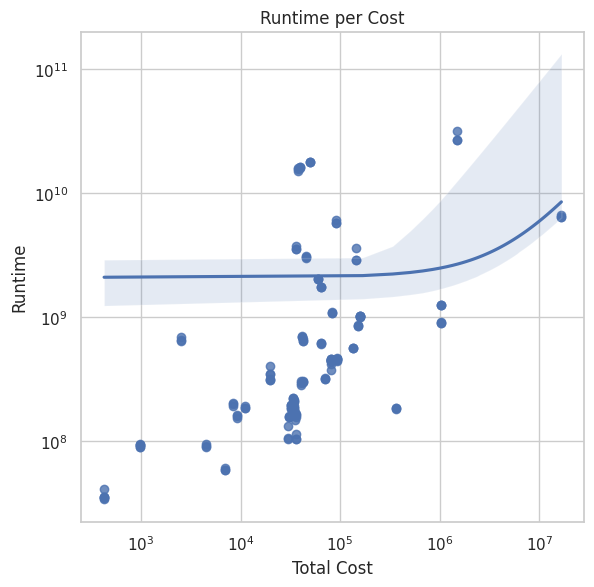

In [49]:
g = sns.regplot(
    data = df,
    x = "Total Cost",
    y = "exec_time",
    scatter = True,
    
)

g.set(
    title = "Runtime per Cost",
    xlabel = "Total Cost",
    ylabel = "Runtime"
)

g.get_figure().set_size_inches(6, 6)
g.get_figure().tight_layout()

plt.xscale("log")
plt.yscale("log")

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

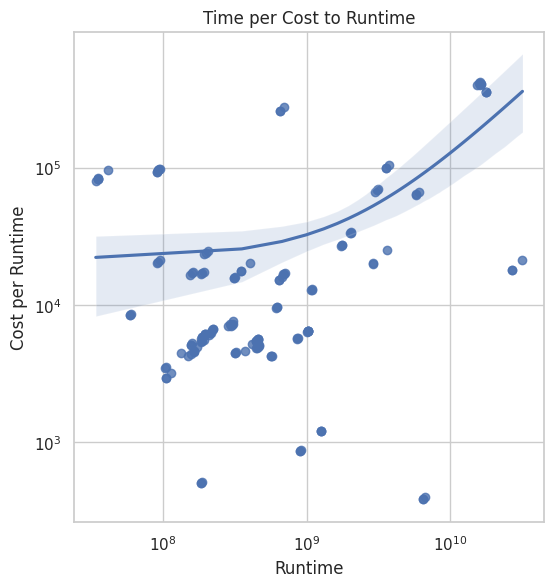

In [50]:
g = sns.regplot(
    data = df,
    x = "exec_time",
    y = "Time per Cost",
    scatter = True,
)

g.set(
    title = "Time per Cost to Runtime",
    xlabel = "Runtime",
    ylabel = "Cost per Runtime"
)

g.get_figure().set_size_inches(6, 6)
g.get_figure().tight_layout()

plt.xscale("log")
plt.yscale("log")

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

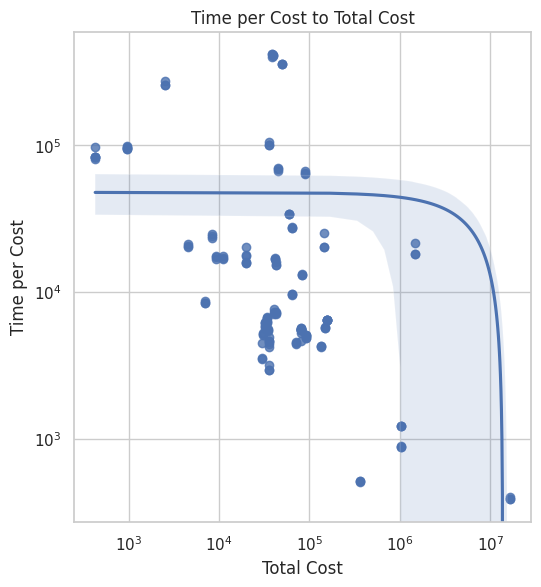

In [54]:
g = sns.regplot(
    data = df,
    x = "Total Cost",
    y = "Time per Cost",
    scatter = True,
)

g.set(
    title = "Time per Cost to Total Cost",
    xlabel = "Total Cost",
    ylabel = "Time per Cost"
)

g.get_figure().set_size_inches(6, 6)
g.get_figure().tight_layout()

plt.xscale("log")
plt.yscale("log")

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

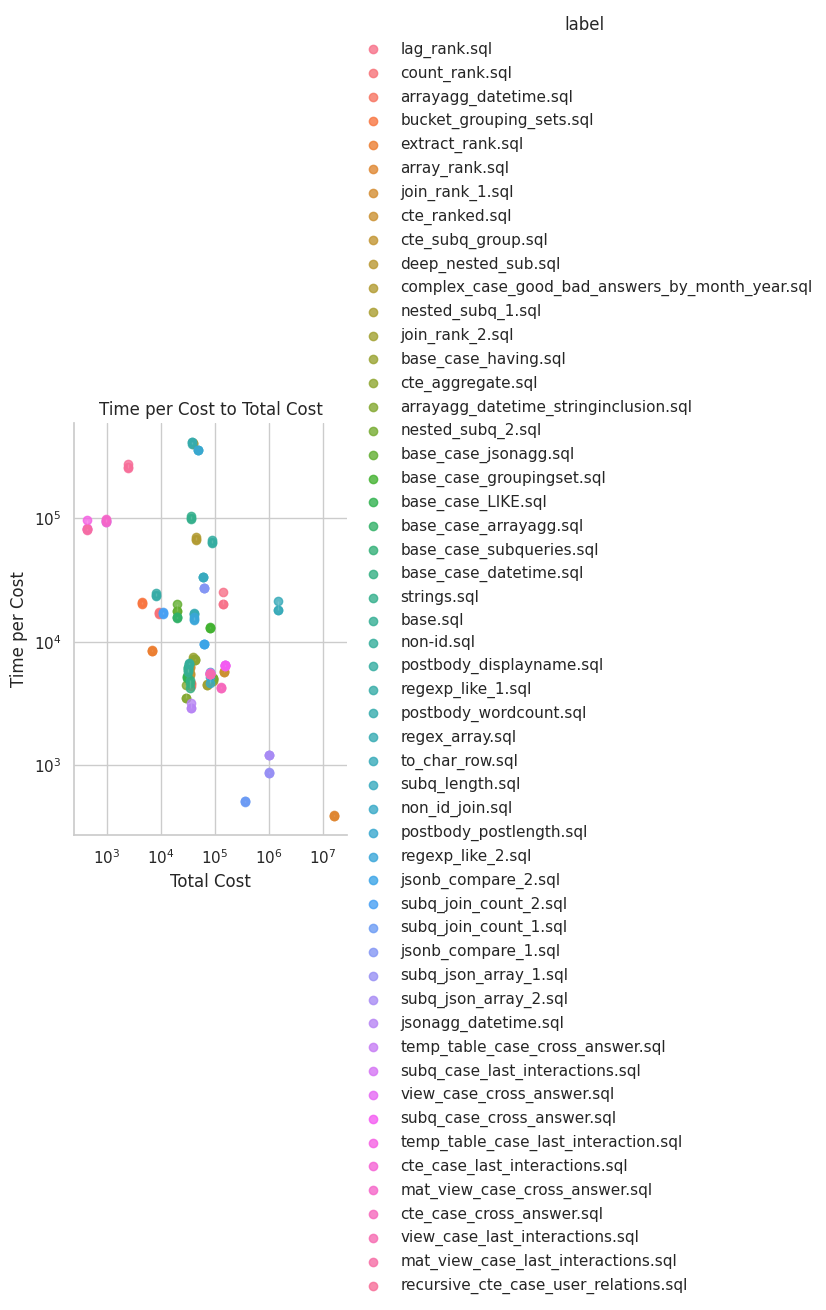

In [66]:
g = sns.lmplot(
    data = df,
    x = "Total Cost",
    y = "Time per Cost",
    hue = "label",
)

g.set(
    title = "Time per Cost to Total Cost",
    xlabel = "Total Cost",
    ylabel = "Time per Cost"
)

plt.xscale("log")
plt.yscale("log")

plt.show

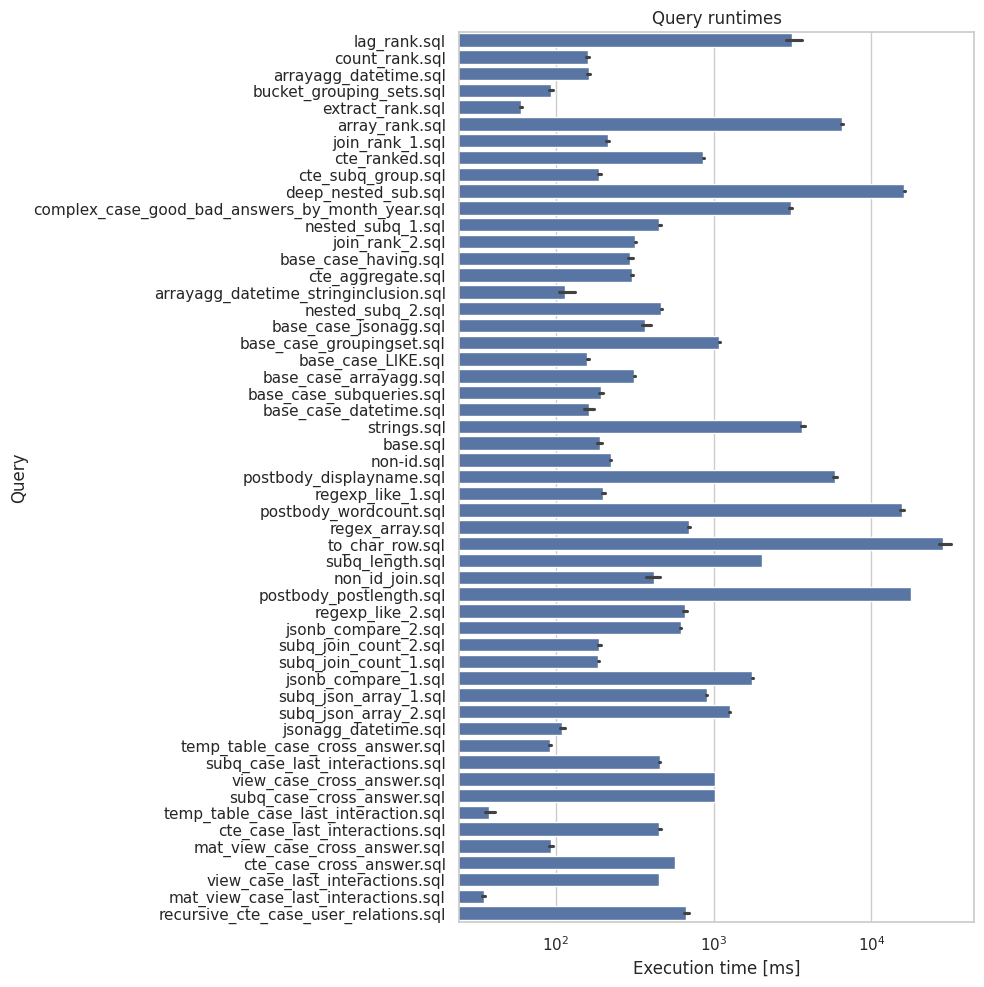

In [58]:
df = pd.read_csv("results.csv")

df["exec_time"] = df["exec_time"] / 1000000

g = sns.barplot(
    data = df,
    x = "exec_time",
    y = "label"
)

g.set(
    title = "Query runtimes",
    xlabel = "Execution time [ms]",
    ylabel = "Query"
)

g.get_figure().set_size_inches(10, 10)
g.get_figure().tight_layout()

plt.xscale("log")

plt.show()